#Implémentation de la classe
Vous pouvez modifier :
- la taille du plateau 
- les coordonnées de l'état final, des états finaux, des obstacles (ou pas d'obstacles)
- les conditions venteuses (direction(s), force, impacts sur l'agent)
- l'arrêt de l'entraînement avec une condition sur le nombre d'épisodes ou sur le nombre d'actions nécessaire pour finir un épisode de test

Les zones du code correspondantes sont marquées en commentaires.

Avec l'environnement de taille 300*300, la convergence est longue (plusieurs dizaines de minutes généralement). Il est donc préférable de prendre un petit environnement.

In [ ]:
import numpy as np
import random as rd
import math 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import pdb 



class Plateau(object):

    def __init__(self, cas = 'c', motivation_intrinseque = True, epsilon = 0, alpha = 0.1, gamma = 0.99):
      # -------- MODIFIABLE : taille du plateau, coordonnées de l'état final, des états finaux, des obstacles, ou non présence d'obstacles, nombre maximum d'actions dans l'épisode de test --------
        self.taille_plateau = 300
        self.cas = cas
        self.nb_max_actions_episode_test = 1000
        if self.cas == 'a' or self.cas == 'b':         
          self.x_init = 100
          self.y_init = 200
          self.x_final = [199,200,201]
          self.y_final = [99,100,101]
          if self.cas == 'a' :
            self.nb_max_actions_episode_test = 134
          if self.cas == 'b':
            self.nb_max_actions_episode_test = 198
        elif self.cas == 'c':  
          self.taille_plateau = 50       #le cas c est diminué en terme de taille d'environnement comme dans le rapport
          self.x_init = 34
          self.y_init = 17
          self.x_final = [15,16,17,18,19]
          self.y_final = [32,33,34,35,36]
          self.taille_max_episode_test = 16
        self.x_obstacles = []
        self.y_obstacles = []
      # -------- MODIFIABLE --------
        self.motivation_intrinseque = motivation_intrinseque   
        self.epsilon = epsilon    
        self.alpha = alpha
        self.gamma = gamma
        self.x = self.x_init
        self.y = self.y_init
        self.q = np.zeros((self.taille_plateau, self.taille_plateau,4))
        self.a = np.zeros((self.taille_plateau, self.taille_plateau))
        self.parcours_effectue = np.zeros((self.taille_plateau, self.taille_plateau))
        self.nb_parcours_effectues = 0
        self.buffer = [[]]
        self.tab_heat = np.zeros((self.taille_plateau, self.taille_plateau))
        self.tab_dir = np.zeros((self.taille_plateau, self.taille_plateau), dtype=np.str)


    def initialiser_agent(self):
        self.x = self.x_init 
        self.y = self.y_init 


    def recuperer_direction_vent(self, x, y):
      # -------- MODIFIABLE : conditions venteuses (direction selon les coordonnées) --------
      if self.cas == 'a':
        return 45 #pour que le déplacement vers le nord et vers l'est soient impactées
      elif self.cas == 'b':
        if y > self.taille_plateau / 2:
          return 180
        elif y <= self.taille_plateau / 2:
          return 90 
      elif self.cas == 'c':
        if y > self.taille_plateau / 2:
          return 180
        elif y <= self.taille_plateau / 2:
          return 45 #pour que le déplacement vers le nord et vers l'est soient impactées
      # -------- MODIFIABLE --------

    
    def recuperer_vitesse_vent(self, x, y):
      # -------- MODIFIABLE : conditions venteuses (force selon les coordonnées) --------
      if self.cas == 'a':
        return 3 #pour 50 km/h
      elif self.cas == 'b':
        if y > self.taille_plateau / 2:
          return 3 
        elif y <= self.taille_plateau / 2:
          return 2 #pour 20 km/h
      elif self.cas == 'c':
        if y > self.taille_plateau / 2:
          return 3
        elif y <= self.taille_plateau / 2:
          return 2
      # -------- MODIFIABLE --------


    def calculer_facteur_deplacement(self, nouveau_x, nouveau_y):
      #calcul du facteur qui va être multiplié à la distance de base (=1) en fonction de la direction du vent
        distance = math.sqrt((self.x - nouveau_x) * (self.x - nouveau_x) + (self.y - nouveau_y) * (self.y - nouveau_y))
        direction_vent = self.recuperer_direction_vent((self.x + nouveau_x) / 2.0, (self.y + nouveau_y) / 2.0)
        vitesse_vent = self.recuperer_vitesse_vent(nouveau_x, nouveau_y)
        direction_agent = math.atan2(nouveau_y - self.y, nouveau_x - self.x)*180/math.pi
        
        #On ramène entre 0 et 360
        if direction_agent < 0:
            direction_agent = direction_agent + 360
        #calcul de la différence angulaire
        alpha = abs(direction_agent - direction_vent)
        #On se ramène à une différence entre 0 et 180 :
        if alpha > 180:
            alpha = 360 - alpha
        # -------- MODIFIABLE : conditions venteuses(force et impact sur l'agent) --------
        if alpha <= 50:
          return vitesse_vent
        else:
          return 1
        # -------- MODIFIABLE --------
 

    def deplacer_en_exploration(self, recompense, val_contrainte):
            #on détermine aléatoirement ou selon les récompenses intrinsèques, la direction et le sens vers la nouvelle position

            if self.motivation_intrinseque is True:
              #calcul de la récompense intrinsèque pour chaque état atteignable depuis l'état courant
              recompenses_intrinseques = [0,0,0,0]
              for i in range(len(self.buffer)):
                  recompenses_intrinseques[0] += ((abs(self.buffer[i][1] - (self.x - 1)) + abs(self.buffer[i][0] - (self.y))) / len(self.buffer))*1
                  recompenses_intrinseques[1] += ((abs(self.buffer[i][1] - (self.x)) + abs(self.buffer[i][0] - (self.y - 1))) / len(self.buffer))*1
                  recompenses_intrinseques[2] += ((abs(self.buffer[i][1] - (self.x)) + abs(self.buffer[i][0] - (self.y + 1))) / len(self.buffer))*1
                  recompenses_intrinseques[3] += ((abs(self.buffer[i][1] - (self.x + 1)) + abs(self.buffer[i][0] - (self.y))) / len(self.buffer))*1
              #recherche du mouvement qui maximise l'espérance de récompense intrinsèque
              cpt = 0
              max_q = np.max(recompenses_intrinseques)
              occurences_max = []
              for i in range(4):
                  if recompenses_intrinseques[i] == max_q :
                      occurences_max.append(cpt)
                  cpt += 1
              indice_max_q = occurences_max[rd.randint(0,len(occurences_max)-1)]

            else:
              #on choisit une action aléatoirement
              indice_max_q = rd.randint(0,3)

            #on appelle la méthode appropriée selon l'action choisie
            if indice_max_q == 0:
                if recompense == "oui":
                    self.deplacer_horizontalement(-1, "oui")
                else:
                     self.deplacer_horizontalement(-1, "non")
            elif indice_max_q == 3:
                if recompense == "oui":
                    self.deplacer_horizontalement(1, "oui")
                else:
                    self.deplacer_horizontalement(1, "non")
            elif indice_max_q == 1:
                if recompense == "oui":
                    self.deplacer_verticalement(-1, "oui")
                else:
                    self.deplacer_verticalement(-1, "non")
            elif indice_max_q ==2:
                if recompense == "oui":
                    self.deplacer_verticalement(1, "oui")
                else:
                    self.deplacer_verticalement(1, "non")

    
    def mettre_a_jour_q_table(self, recompense, nouveau_x, nouveau_y, conditions_limites):
      #la récompense extrinsèque est calculée avec la Q-Function pour le couple état-action choisi. Il est déterminé par des tests de différence selon x et y
      #si l'agent sort de l'environnement, alors l'état suivant considéré est celui courant

        if nouveau_x - self.x > 0:
            if conditions_limites is False:
                self.q[self.y, self.x, 3] = self.q[self.y, self.x, 3] + self.alpha * (recompense + self.gamma * np.max(self.q[nouveau_y, nouveau_x]) - self.q[self.y, self.x, 3])
            else:
                self.q[self.y, self.x, 3] = self.q[self.y, self.x, 3] + self.alpha * (recompense + self.gamma * np.max(self.q[self.y, self.x]) - self.q[self.y, self.x, 3])
        elif nouveau_x - self.x < 0:
            if conditions_limites is False:
                self.q[self.y, self.x, 0] = self.q[self.y, self.x, 0] + self.alpha * (recompense + self.gamma * np.max(self.q[nouveau_y, nouveau_x]) - self.q[self.y, self.x, 0])
            else:
                self.q[self.y, self.x, 0] = self.q[self.y, self.x, 0] + self.alpha * (recompense + self.gamma * np.max(self.q[self.y, self.x]) - self.q[self.y, self.x, 0])
        elif nouveau_y - self.y > 0:
            if conditions_limites is False:
                self.q[self.y, self.x, 2] = self.q[self.y, self.x, 2] + self.alpha * (recompense + self.gamma * np.max(self.q[nouveau_y, nouveau_x]) - self.q[self.y, self.x, 2])
            else:
                self.q[self.y, self.x, 2] = self.q[self.y, self.x, 2] + self.alpha * (recompense + self.gamma * np.max(self.q[self.y, self.x]) - self.q[self.y, self.x, 2])
        elif nouveau_y - self.y < 0:
            if conditions_limites is False:
                self.q[self.y, self.x, 1] = self.q[self.y, self.x, 1] + self.alpha * (recompense + self.gamma * np.max(self.q[nouveau_y, nouveau_x]) - self.q[self.y, self.x, 1])
            else:
                self.q[self.y, self.x, 1] = self.q[self.y, self.x, 1] + self.alpha * (recompense + self.gamma * np.max(self.q[self.y, self.x]) - self.q[self.y, self.x, 1])
        
        
    def deplacer_horizontalement(self, sens, recompense):
      #l'agent est déplacé horizontalement vers la gauche (sens = -1) ou la droite (sens = 1). La nouvelle espérance de récompense extrinsèque est, ou non, calculée

      #le nouvel état est déterminé selon l'action choisie et le vent
        nouveau_x = self.x + sens
        nouveau_x_selon_vent = self.x + sens * self.calculer_facteur_deplacement(nouveau_x, self.y)

      #aux limites, le déplacement ne se fait pas vers l'extérieur du plateau
        if self.x - 5 <= 0 and sens < 0:
            self.mettre_a_jour_q_table(0, nouveau_x_selon_vent, self.y, True) 
        elif self.x + 5 >= self.taille_plateau and sens > 0:
            self.mettre_a_jour_q_table(0, nouveau_x_selon_vent, self.y, True)
      
      #la nouvelle espérance de récompense est calculée selon l'état suivant
        else:
            if recompense == "oui":
              if nouveau_x_selon_vent in self.x_final and self.y in self.y_final:
                self.mettre_a_jour_q_table(1, nouveau_x_selon_vent, self.y, False)
              elif nouveau_x_selon_vent in self.x_obstacles and self.y in self.y_obstacles:
               self.mettre_a_jour_q_table(-1, nouveau_x_selon_vent, self.y, False)
              else:
                self.mettre_a_jour_q_table(0, nouveau_x_selon_vent, self.y, False)

      #l'état est mis à jour
            self.x = nouveau_x_selon_vent


    def deplacer_verticalement(self, sens, recompense):
      #l'agent est déplacé horizontalement vers la gauche (sens = -1) ou la droite (sens = 1). La nouvelle espérance de récompense extrinsèque est, ou non, calculée

      #le nouvel état est déterminé selon l'action choisie et le vent
        nouveau_y = self.y + sens
        nouveau_y_selon_vent = self.y + sens * self.calculer_facteur_deplacement(self.x, nouveau_y)   

      #aux limites, le déplacement ne se fait pas vers l'extérieur du plateau
        if self.y - 5 <= 0 and sens < 0:
            self.mettre_a_jour_q_table(0, self.x, nouveau_y_selon_vent, True)
        elif self.y + 5 >= self.taille_plateau and sens > 0:
            self.mettre_a_jour_q_table(0, self.x, nouveau_y_selon_vent, True)

      #la nouvelle espérance de récompense est calculée selon l'état suivant
        else:
          if recompense == "oui":
            if nouveau_y_selon_vent in self.y_final and self.x in self.x_final:
              self.mettre_a_jour_q_table(1, self.x, nouveau_y_selon_vent, False)
            elif nouveau_y_selon_vent in self.y_obstacles and self.x in self.x_obstacles:
              self.mettre_a_jour_q_table(-1, self.x, nouveau_y_selon_vent, False)
            else:
              self.mettre_a_jour_q_table(0, self.x, nouveau_y_selon_vent, False)   

      #l'état est mis à jour
          self.y = nouveau_y_selon_vent


    def deplacer_en_exploitation(self, recompense, intrinseque):
      #déplacement extrinsèquement motivé de l'agent + intrinsèquement motivé optionnellement

        if self.motivation_intrinseque == "oui":
            #calcul de la récompense intrinsèque pour chaque état atteignable depuis l'état courant
            recompenses_intrinseques = [0,0,0,0]
            for i in range(len(self.buffer)):
                recompenses_intrinseques[0] += ((abs(self.buffer[i][1] - (self.x - 1)) + abs(self.buffer[i][0] - (self.y))) / len(self.buffer))*1
                recompenses_intrinseques[1] += ((abs(self.buffer[i][1] - (self.x)) + abs(self.buffer[i][0] - (self.y - 1))) / len(self.buffer))*1
                recompenses_intrinseques[2] += ((abs(self.buffer[i][1] - (self.x)) + abs(self.buffer[i][0] - (self.y + 1))) / len(self.buffer))*1
                recompenses_intrinseques[3] += ((abs(self.buffer[i][1] - (self.x + 1)) + abs(self.buffer[i][0] - (self.y))) / len(self.buffer))*1

            #addition de la récompense intrinsèque et extrinsèque pour chaque état atteignable depuis l'état courant
            recompenses_totales = [0,0,0,0]
            for i in range(4):
                recompenses_totales[i] = recompenses_intrinseques[i] + self.q[self.y, self.x, i]
            
            #recherche du mouvement qui maximise l'espérance de récompense
            cpt = 0
            max_q = np.max(recompenses_totales)
            occurences_max = []
            for i in range(4):
                if recompenses_totales[i] == max_q :
                    occurences_max.append(cpt)
                cpt += 1
            indice_max_q = occurences_max[rd.randint(0,len(occurences_max)-1)]

        else:
            #recherche du mouvement qui maximise l'espérance de récompense extrinsèque
            cpt = 0
            max_q = np.max(self.q[self.y,self.x])
            occurences_max = []
            for i in range(4):
                if self.q[self.y,self.x,i] == max_q :
                    occurences_max.append(cpt)
                cpt += 1

            indice_max_q = occurences_max[rd.randint(0,len(occurences_max)-1)]
            
        #mise à jour de la position si hors conditions limites
        if indice_max_q == 0:
            if self.x - 4 >= 0:
                if recompense == "oui":
                    self.deplacer_horizontalement(-1,"oui")
                else:
                    self.deplacer_horizontalement(-1,"non")
        if indice_max_q == 1:
            if self.y - 4 >= 0:
                if recompense == "oui":
                    self.deplacer_verticalement(-1,"oui")
                else:
                    self.deplacer_verticalement(-1,"non")
        if indice_max_q == 2:
            if self.y + 4 <= self.taille_plateau:
                if recompense == "oui":
                    self.deplacer_verticalement(1,"oui")
                else:
                    self.deplacer_verticalement(1,"non")
        if indice_max_q == 3:
            if self.x + 4 <= self.taille_plateau:
                if recompense == "oui":
                    self.deplacer_horizontalement(1,"oui")
                else:
                    self.deplacer_horizontalement(1,"non")

          
    def effectuer_un_episode_en_apprentissage(self):
      #l'agent parcourt l'environnement jusqu'à arriver sur un des états finaux

      #initialisation 
        self.initialiser_agent()
        if self.epsilon < 100:
          self.epsilon += 1
        self.buffer = [[]]
        self.buffer[0] = [self.y, self.x]
        nb_actions = 0
        while (self.x not in self.x_final or self.y not in self.y_final):   
          # -------- MODIFIABLE -------- afficher les coordonnées de l'agent pendant le parcours         
            #if nb_actions %25 == 0:
             # print("Action numéro ", nb_actions, ": x = ", self.x, ", y = ", self.y)
          # -------- MODIFIABLE -------- afficher les coordonnées de l'agent pendant le parcours
            nb_actions += 1
            #choix de si le mouvement est en exploration ou exploitation
            if rd.randint(1,10000) > self.epsilon:
                self.deplacer_en_exploration("oui",-1)
            else:
              if self.motivation_intrinseque is True:
                self.deplacer_en_exploitation("oui","oui")
              else:
                self.deplacer_en_exploitation("oui","non")
            
            #on ajoute l'état dans le buffer et on supprime le plus ancien ajouté s'il a atteint sa taille maximale
            self.buffer.append([self.y, self.x])
            if len(self.buffer)>= 100:
              del self.buffer[0]      

               
    def lancer_apprentissage(self):
      #des épisodes sont lancés tant que nb_episode n'a pas atteint la valeur voulue ou que les épisodes de tests ne sont pas réalisés en moins de "" d'actions.
      #Affichage du parcours optimal à la fin

        nb_episode = 0
        self.epsilon = 0
        # -------- MODIFIABLE : arrêt de l'entraînement au bout d'un certain nombre d'épisodes ou quand l'épisode de test se fait avec un nombre d'action suffisamment petit --------
        #while nb_episode <= 10000:
        while self.effectuer_un_episode_de_test(False) > self.nb_max_actions_episode_test:
        # -------- MODIFIABLE --------
            nb_episode += 1
            self.effectuer_un_episode_en_apprentissage()
            self.nb_parcours_effectues += 1
            #if self.nb_parcours_effectues % 25 == 0:
            print ("Nombre d'épisodes : ", "---------------------------",self.nb_parcours_effectues, "---------------------------")
        print("\n", "Nombre total d'épisodes effectués : ", self.nb_parcours_effectues, "\n")

        #on affiche le parcours effectué

        self.effectuer_un_episode_de_test(True)

        #calcul des actions optimales pour chaque état. Marquage : gauche = <, haut = ^, droite = >, bas = v
        tab_dir = np.zeros((self.taille_plateau, self.taille_plateau), dtype=np.str)
        max_q = 0
        for i in range(self.taille_plateau):
          for j in range(self.taille_plateau):
            cpt = 0
            max_q = np.max(self.q[i,j])
            occurences_max = []
            for k in range(4):
              if self.q[i,j,k] == max_q :
                occurences_max.append(cpt)
              cpt += 1            
            indice_max_q = occurences_max[rd.randint(0,len(occurences_max)-1)]
            if max_q == 0:
              tab_dir[i,j] = '_'              
            else:
              if indice_max_q == 0:
                tab_dir[i,j] = '<'
              if indice_max_q == 1:
                tab_dir[i,j] = '^'
              if indice_max_q == 2:
                tab_dir[i,j] = 'v'
              if indice_max_q == 3:
                tab_dir[i,j] = '>'

        #marquage de l'état de départ (=1)/d'arrivée (=2), du/des obstacle(s) (=x)
        for i in range(5):
          for j in range(5):
            tab_dir[self.y_final[j],self.x_final[i]] = '2'
        tab_dir[self.y_init,self.x_init] = '1'
        for i in range(len(self.y_obstacles)):
          for j in range(len(self.x_obstacles)):
            tab_dir[self.y_obstacles[i],self.x_obstacles[j]] = 'x'
        

        #affichage du graphique
        plt.figure(figsize = (30,30))
        figure = sns.heatmap(self.parcours_effectue, annot = tab_dir, fmt= '', cbar=False, cmap= 'Reds')
        plt.show()


    def effectuer_un_episode_de_test(self, afficher_parcours):
      #l'épisode est effectué avec seulement de l'exploitation et sans motivation intrinsèque. Un nombre maximal de déplacements est donné si l'agent est bloqué

      #initialisation 
        self.initialiser_agent()
        nb_deplacements = 0
      # -------- MODIFIABLE : au bout de combien d'actions l'épisode de test se finit automatiquement (si l'agent ne trouve pas l'état final) --------
        while (self.x not in self.x_final or self.y not in self.y_final) and nb_deplacements <= self.nb_max_actions_episode_test:
      # -------- MODIFIABLE --------
            nb_deplacements += 1
            self.a[self.x,self.x] = 0

          #si ce parcours doit être affiché, la matrice correspondante est remplie
            if afficher_parcours == True:
              self.parcours_effectue[self.y, self.x] += 1    

            self.deplacer_en_exploitation("non","non")
            self.a[self.x,self.x] = 1
            
        if afficher_parcours is True:
          print("Nombre d'actions effectuées : ", nb_deplacements)

        return nb_deplacements 

#**Entraînement**

A la fin de l'apprentissage, le chemin optimal est affiché.










Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Nombre d'épisodes :  --------------------------- 5006 ---------------------------
Nombre d'épisodes :  --------------------------- 5007 ---------------------------
Nombre d'épisodes :  --------------------------- 5008 ---------------------------
Nombre d'épisodes :  --------------------------- 5009 ---------------------------
Nombre d'épisodes :  --------------------------- 5010 ---------------------------
Nombre d'épisodes :  --------------------------- 5011 ---------------------------
Nombre d'épisodes :  --------------------------- 5012 ---------------------------
Nombre d'épisodes :  --------------------------- 5013 ---------------------------
Nombre d'épisodes :  --------------------------- 5014 ---------------------------
Nombre d'épisodes :  --------------------------- 5015 ---------------------------
Nombre d'épisodes :  --------------------------- 5016 ---------------------------
Nombre d'épisodes : 

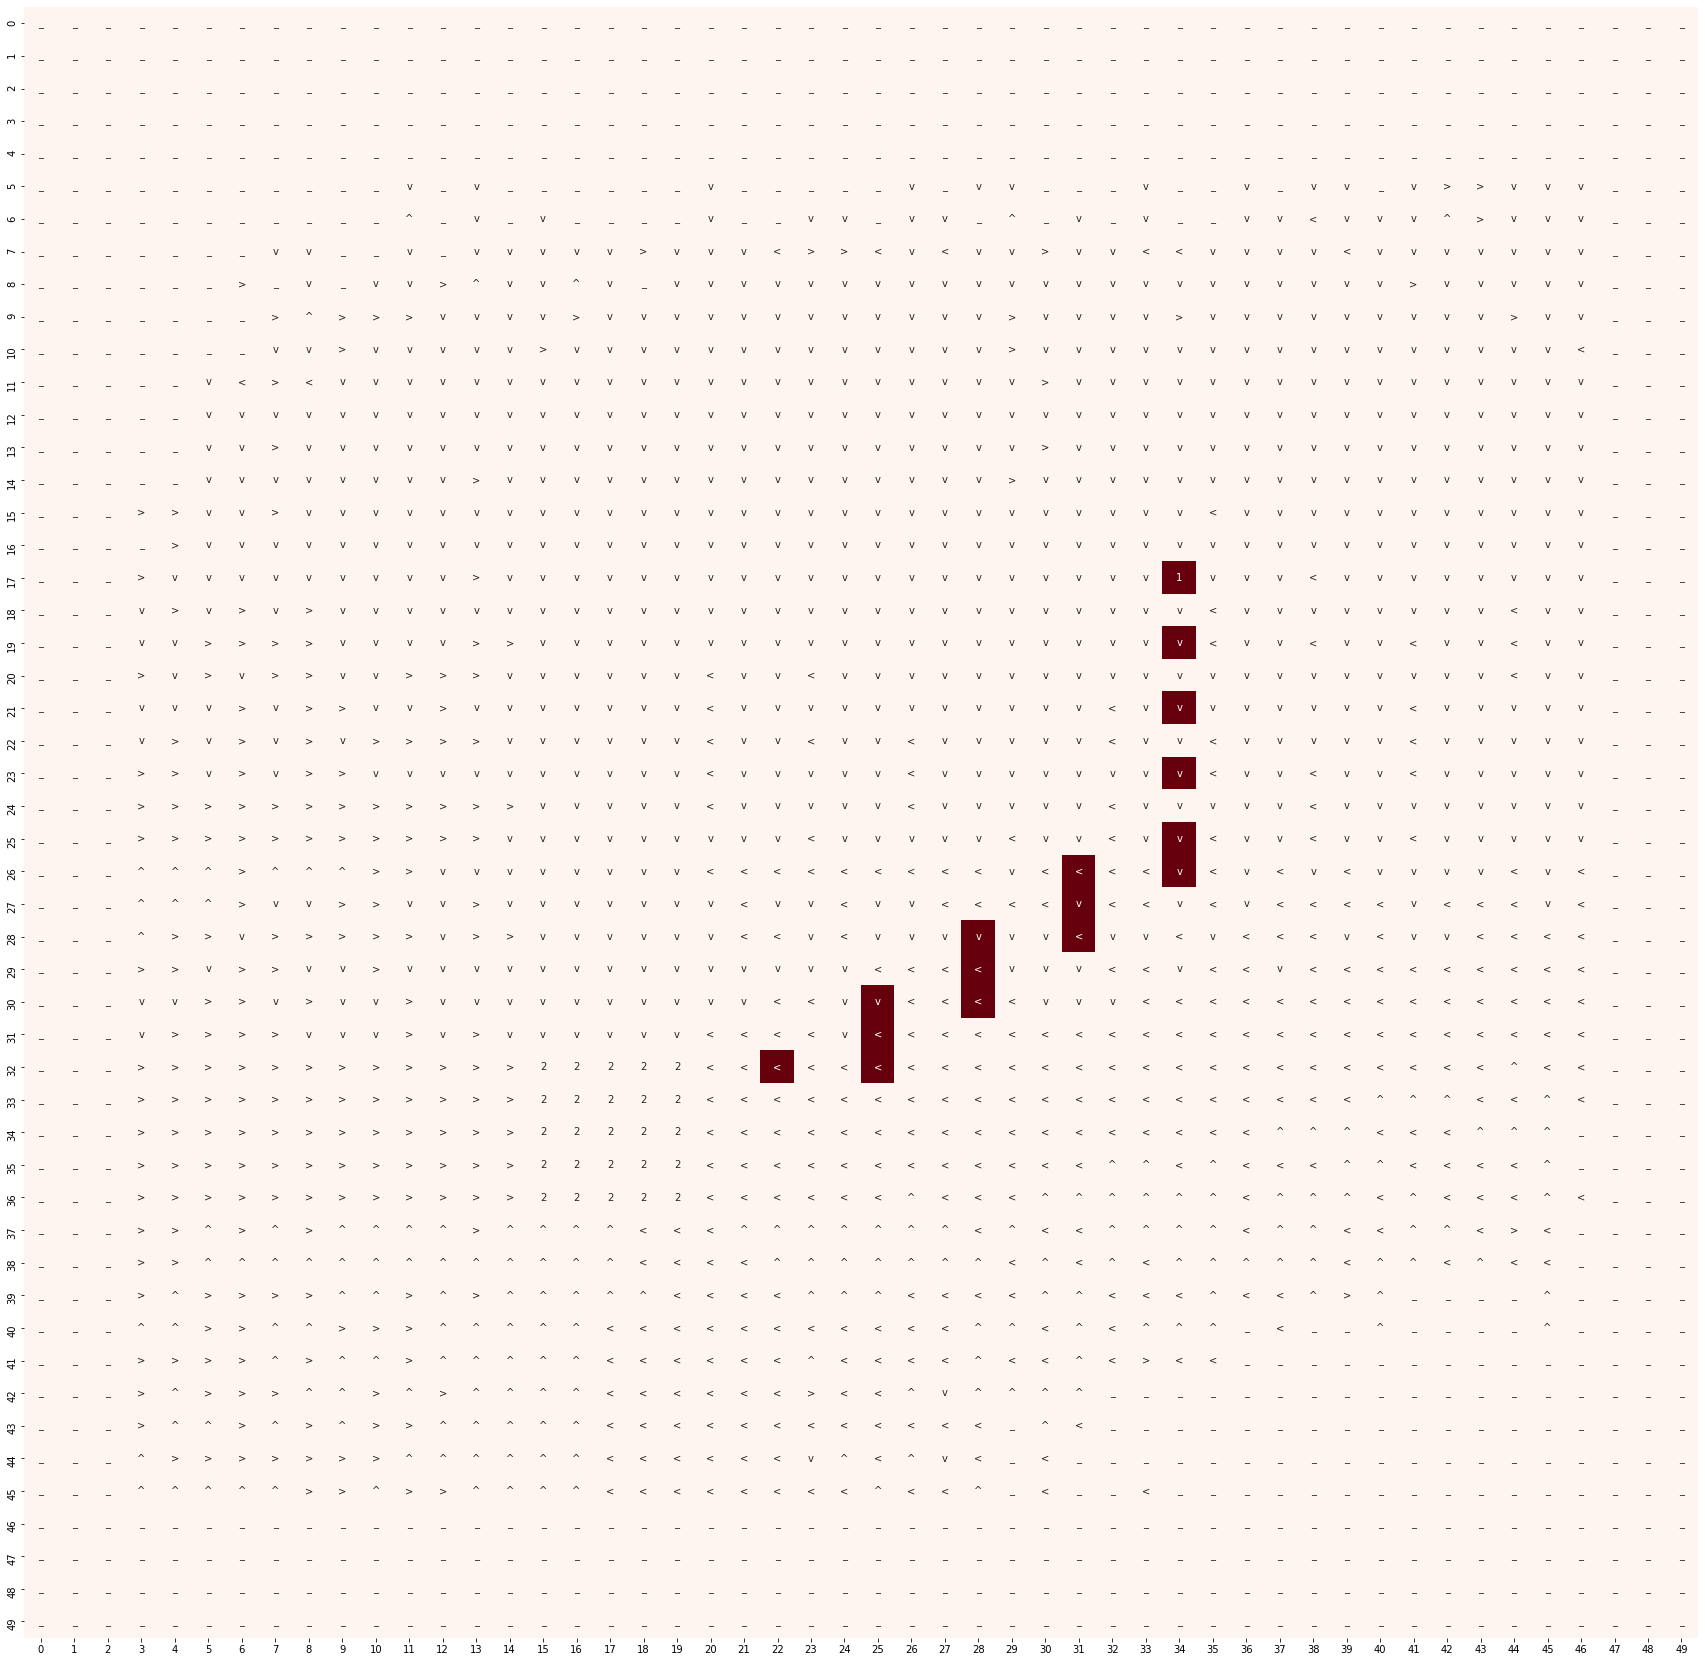

In [ ]:
p = Plateau(cas='c', motivation_intrinseque=False)
p.lancer_apprentissage()

#**Affichage de la distribution des récompenses extrinsèques**

###Préparation des variables

In [ ]:
#implémentation de la matrice des températures. Pour chaque couple, la valeur est calculée en prenant le couple état-action le plus élevée
tab_heat = np.zeros((p.taille_plateau, p.taille_plateau))
for i in range(p.taille_plateau):
  for j in range(p. taille_plateau):
    tab_heat[i,j] = np.max(p.q[i,j])

#implémentation de la matrice des annotations. L'action optimale pour chaque état est indiquée comme suit : gauche = <, droite = >, haut = ^, bas = v.
#1 correspond à l'état initial, 2 aux états finaux, x aux obstacles
tab_dir = np.zeros((p.taille_plateau, p.taille_plateau), dtype=np.str)
max_q = 0
cpt2 = 0
for i in range(p.taille_plateau):
  for j in range(p.taille_plateau):
    cpt = 0
    max_q = np.max(p.q[i,j])
    occurences_max = []
    for k in range(4):
      if p.q[i,j,k] == max_q :
        occurences_max.append(cpt)
      cpt += 1            
    indice_max_q = occurences_max[rd.randint(0,len(occurences_max)-1)]
    if max_q == 0:
      tab_dir[i,j] = ''
      cpt2 += 1
    else:
      if indice_max_q == 0:
        tab_dir[i,j] = '<'
      if indice_max_q == 1:
        tab_dir[i,j] = '^'
      if indice_max_q == 2:
        tab_dir[i,j] = 'v'
      if indice_max_q == 3:
        tab_dir[i,j] = '>'
tab_dir[p.y_init,p.x_init] = '1'
for i in range(5):
  for j in range(5):
    tab_dir[p.y_final[j],p.x_final[i]] = '2'
for i in range(len(p.y_obstacles)):
  for j in range(len(p.x_obstacles)):
    tab_dir[p.y_obstacles[i],p.x_obstacles[j]] = 'x'

###Affichage du graphique

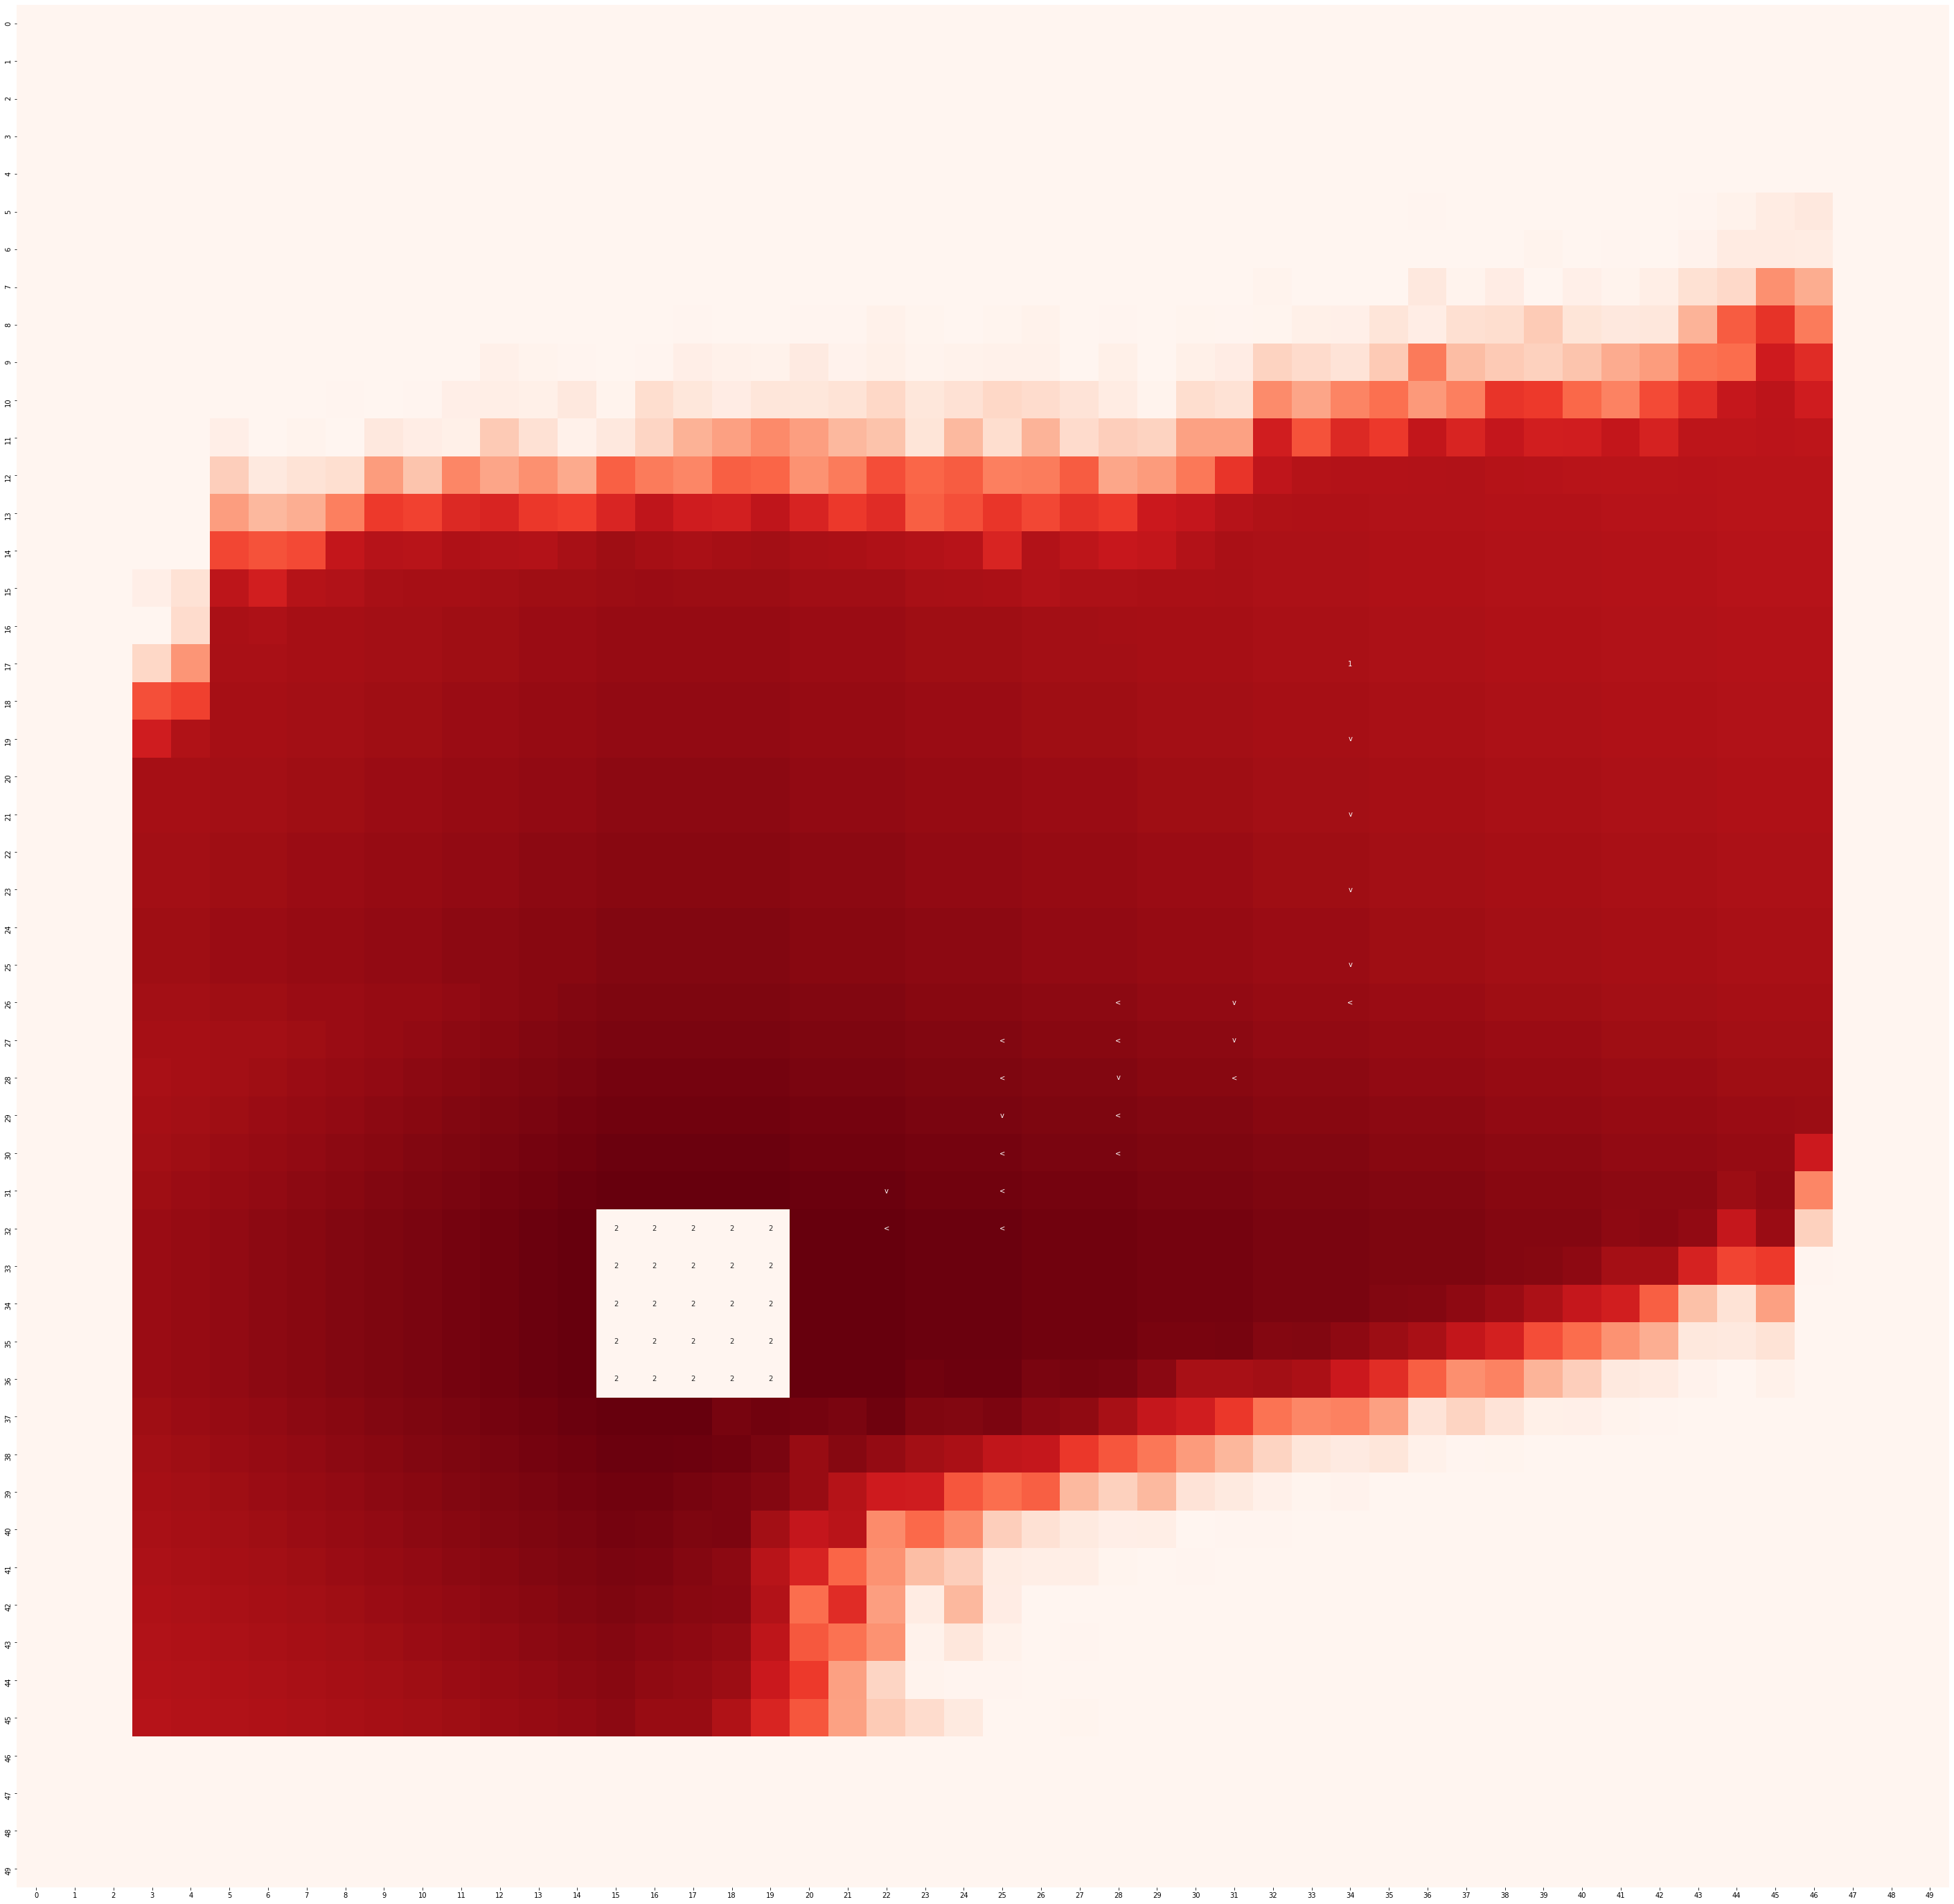

In [ ]:
plt.figure(figsize = (50,50))
figure = sns.heatmap(tab_heat, annot = tab_dir,  fmt= '', cbar=False, cmap= 'Reds')
plt.show()